<!-- # Ross Sea synthetic gravity inversion -->

<!-- import packages -->

In [13]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

import copy
import itertools
import logging
import os
import pathlib
import pickle
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import verde as vd
import xarray as xr
from polartoolkit import maps
from polartoolkit import utils as polar_utils
from tqdm.autonotebook import tqdm

import RIS_gravity_inversion.plotting as RIS_plotting
import RIS_gravity_inversion.synthetic as RIS_synth

os.environ["POLARTOOLKIT_HEMISPHERE"] = "south"

logging.getLogger().setLevel(logging.INFO)

from invert4geom import inversion, plotting, regional, utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<!-- # Get synthetic model data -->

INFO:root:using preprocessed 5km grid since spacing is > 5km


INFO:root:returning grid with new region and/or registration, same spacing
INFO:root:returning grid with new region and/or registration, same spacing


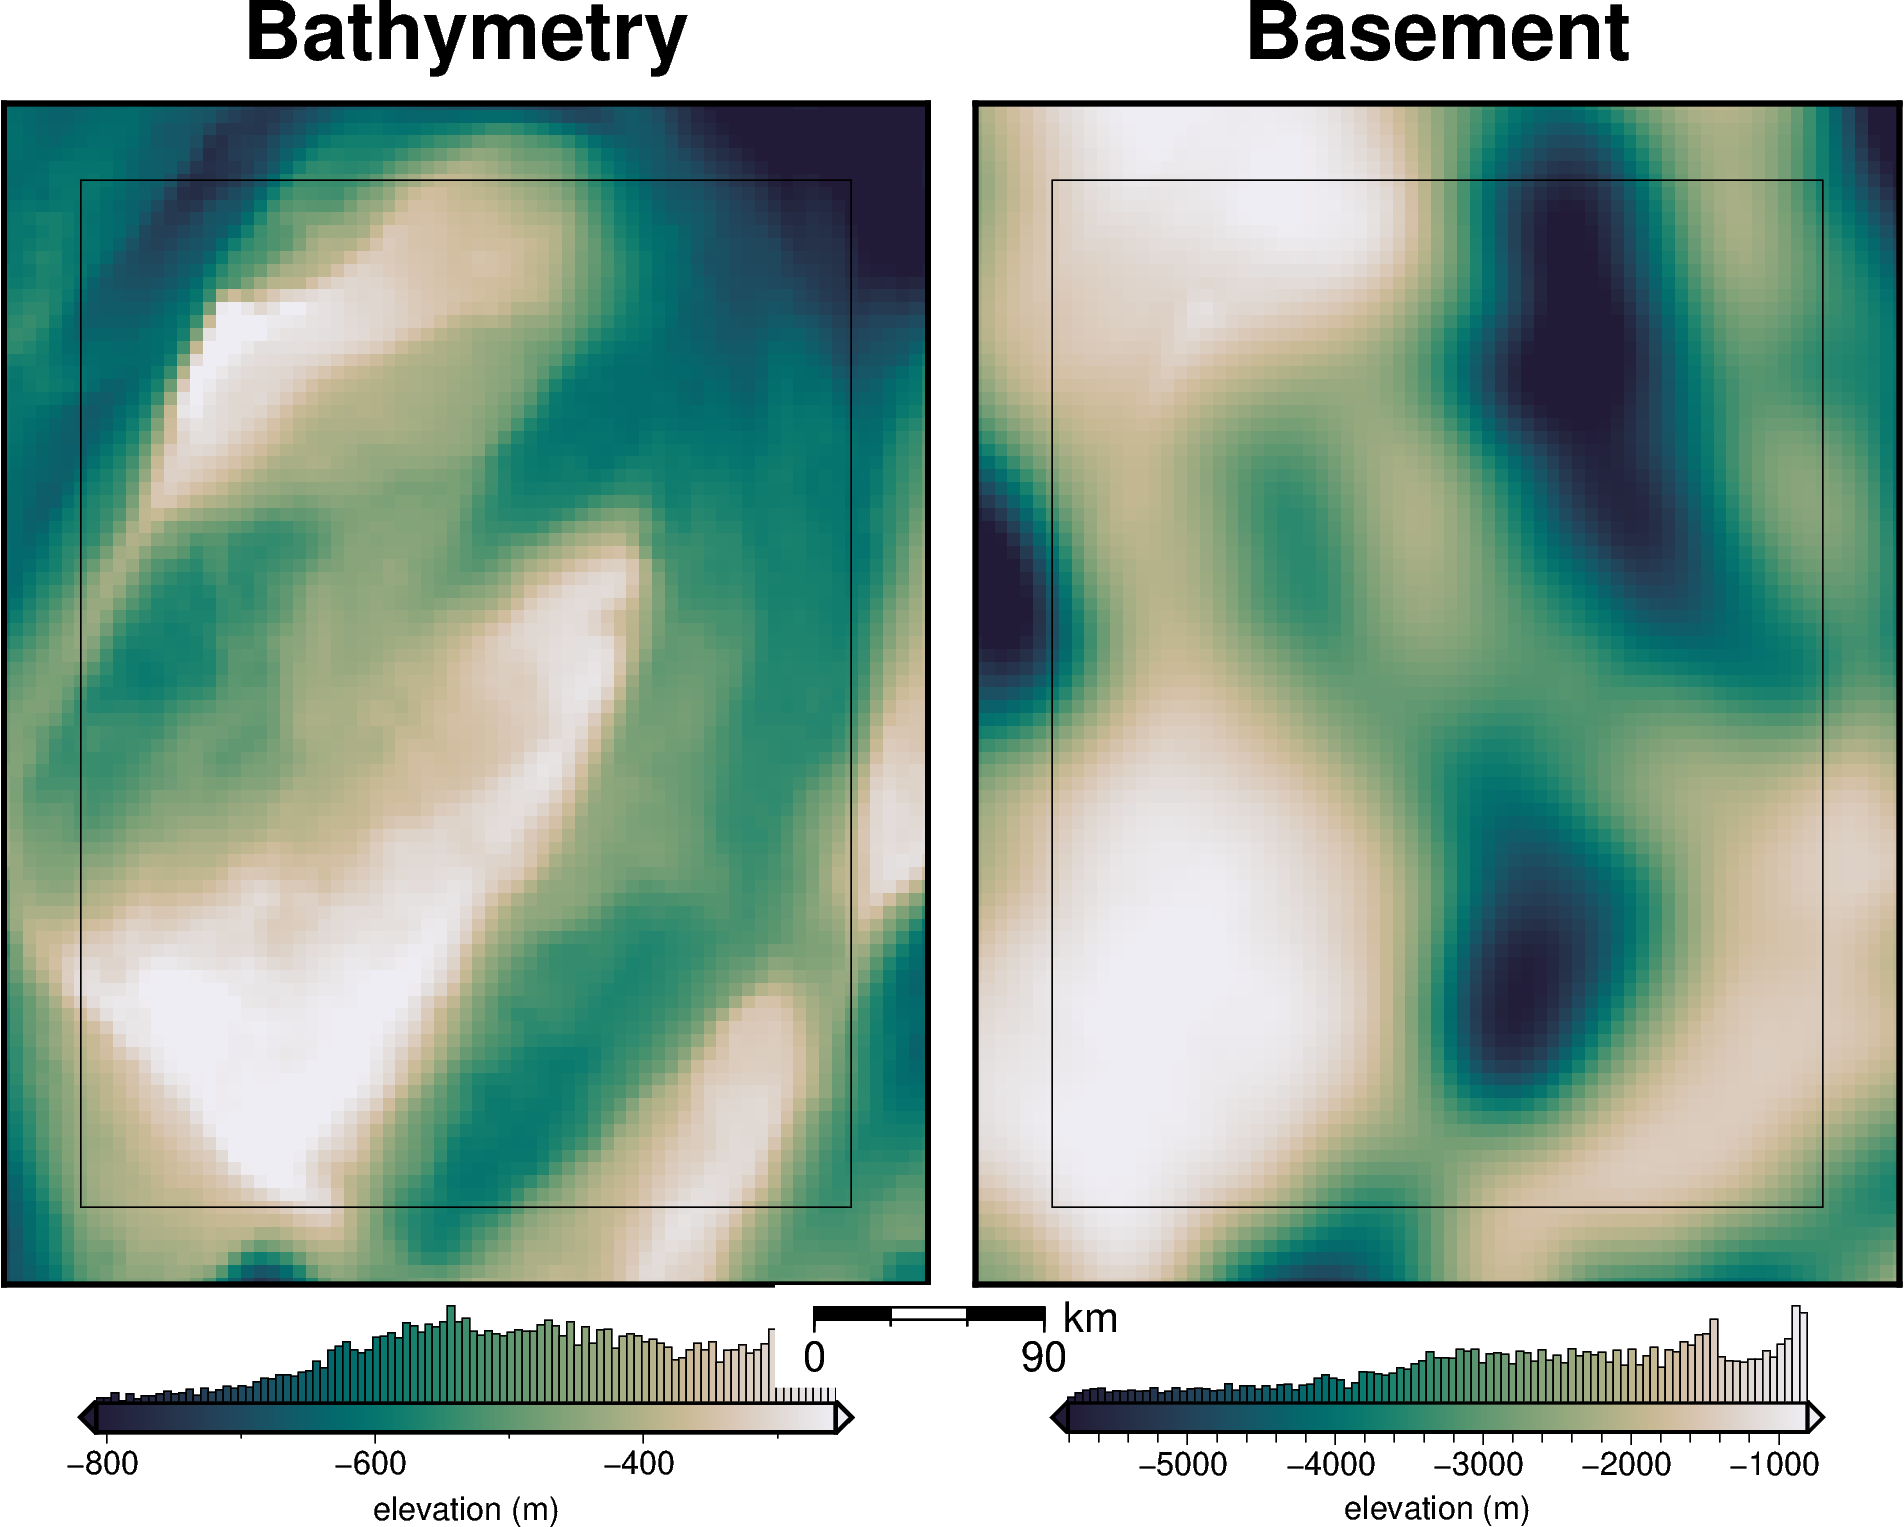

  0%|          | 0/4941 [00:00<?, ?it/s]

  0%|          | 0/4941 [00:00<?, ?it/s]

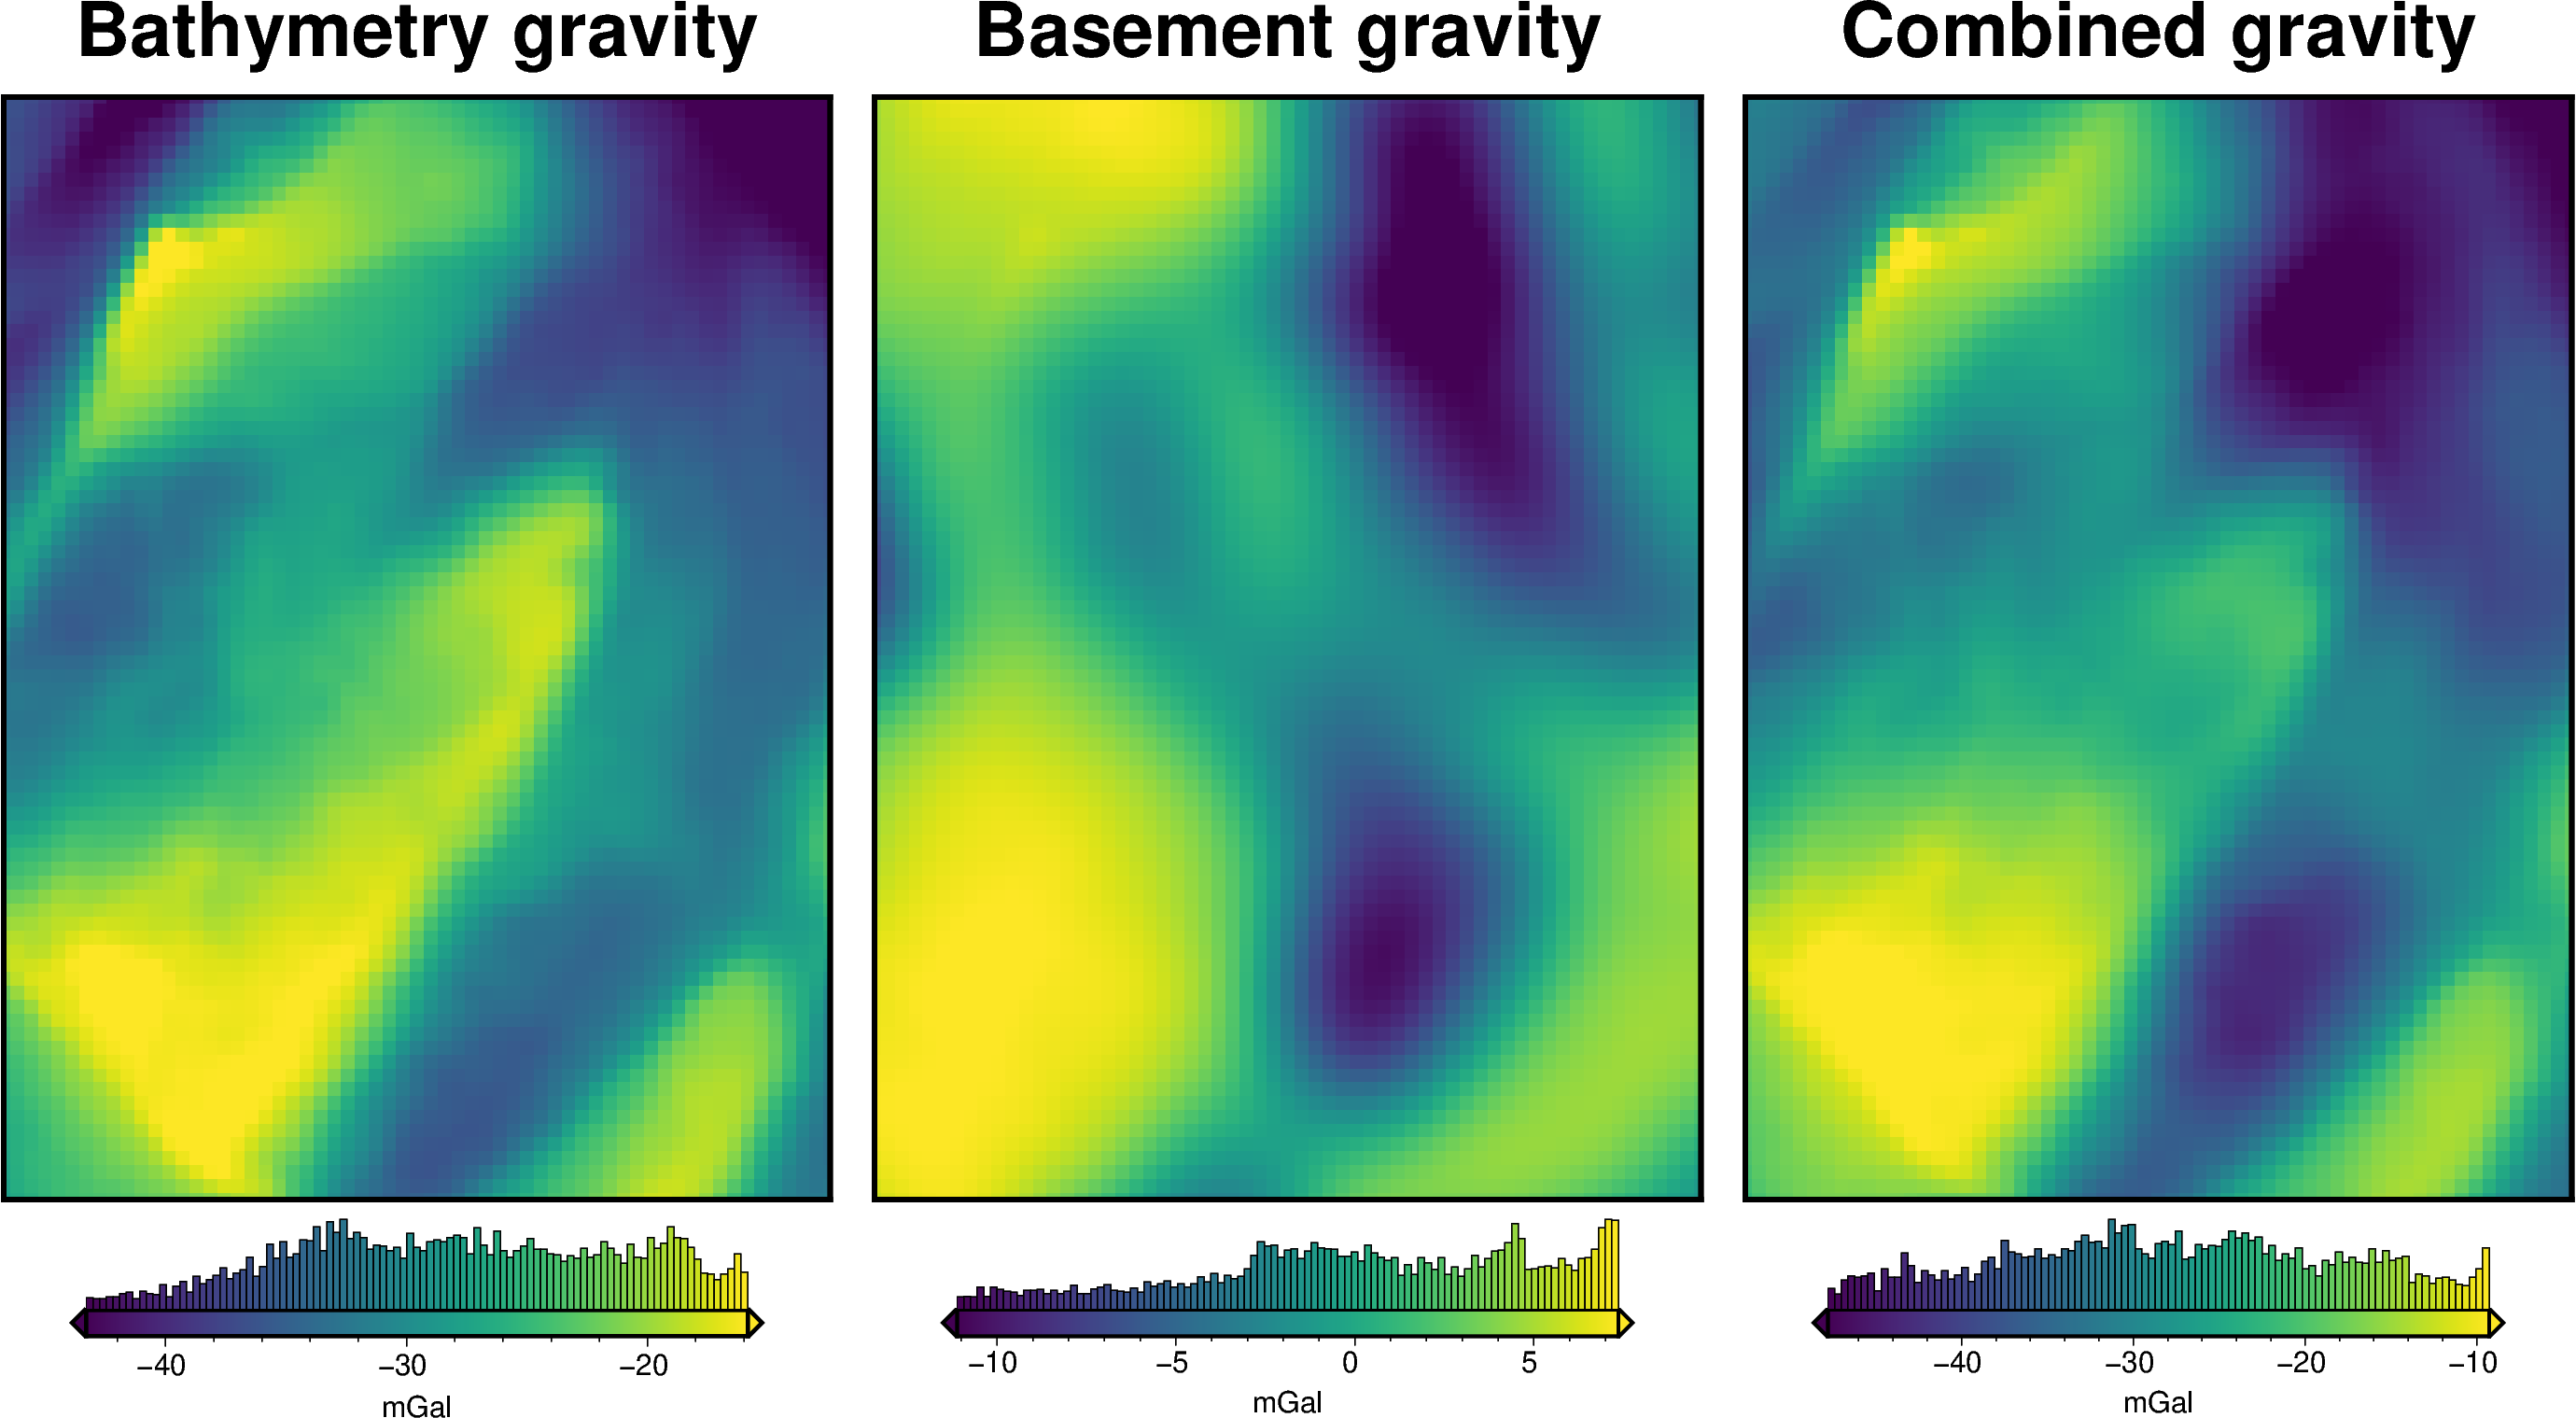

In [14]:
# set grid parameters
spacing = 5e3
inversion_region = (-40e3, 260e3, -1800e3, -1400e3)

true_density_contrast = 1476

bathymetry, basement, original_grav_df = RIS_synth.load_synthetic_model(
    spacing=spacing,
    buffer=spacing * 6,
    basement=True,
    zref=0,
    bathymetry_density_contrast=true_density_contrast,
)
buffer_region = polar_utils.get_grid_info(bathymetry)[1]

In [3]:
# normalize regional gravity between 0 and 1
original_grav_df["basement_grav_normalized"] = (
    vd.grid_to_table(
        utils.normalize_xarray(
            original_grav_df.set_index(["northing", "easting"])
            .to_xarray()
            .basement_grav,
            low=-1,
            high=1,
        )
    )
    .reset_index()
    .basement_grav
)
original_grav_df = original_grav_df.drop(
    columns=["basement_grav", "disturbance", "gravity_anomaly"]
)
original_grav_df

,northing,easting,upward,bathymetry_grav,basement_grav_normalized
0,-1800000.0,-40000.0,1000.0,-28.046289,0.830177
1,-1800000.0,-35000.0,1000.0,-26.714502,0.867672
2,-1800000.0,-30000.0,1000.0,-25.919276,0.898289
3,-1800000.0,-25000.0,1000.0,-25.236960,0.921973
4,-1800000.0,-20000.0,1000.0,-24.610928,0.937189
...,...,...,...,...,...
4936,-1400000.0,240000.0,1000.0,-48.323584,0.243973
4937,-1400000.0,245000.0,1000.0,-48.356131,0.167427
4938,-1400000.0,250000.0,1000.0,-49.079005,0.076264
4939,-1400000.0,255000.0,1000.0,-49.877171,-0.022265


<!-- # Set filename -->

In [8]:
ensemble_path = (
    "../../results/08_constraint_spacing_vs_regional_strength_ensemble_regional_cv"
)
ensemble_fname = f"{ensemble_path}.csv"

In [58]:
num = 8  # CHANGE TO 8

# Define number of constraints in both x and y directions on log scale
constraint_numbers = np.unique(np.round(np.geomspace(2, 20, num)))
constraint_numbers = [int(i) for i in constraint_numbers]
assert len(constraint_numbers) == num

# Define regional strength
regional_strengths = [float(round(x, 2)) for x in np.linspace(0, 50, num)]

print("number of constraints:", constraint_numbers)
print("regional strengths:", regional_strengths)

number of constraints: [2, 3, 4, 5, 7, 10, 14, 20]
regional strengths: [0.0, 7.14, 14.29, 21.43, 28.57, 35.71, 42.86, 50.0]


In [4]:
2 * 2

4

In [3]:
20 * 20

400

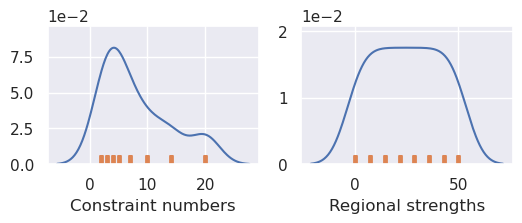

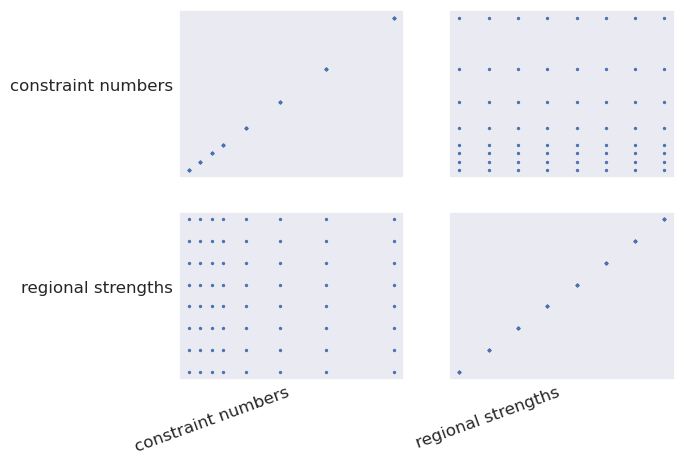

In [59]:
# turn into dataframe
sampled_params_df = pd.DataFrame(
    itertools.product(
        constraint_numbers,
        regional_strengths,
    ),
    columns=[
        "constraint_numbers",
        "regional_strengths",
    ],
)

sampled_params_dict = dict(
    constraint_numbers=dict(sampled_values=sampled_params_df.constraint_numbers),
    regional_strengths=dict(sampled_values=sampled_params_df.regional_strengths),
)

plotting.plot_latin_hypercube(
    sampled_params_dict,
)

# Create starting models and constraints
Only need to do this for unique combinations of constraint_numbers and constraint_noise_levels

In [60]:
sampled_params_df["constraint_points_fname"] = pd.Series()
sampled_params_df["constraints_starting_rmse"] = pd.Series()
sampled_params_df["starting_bathymetry_fname"] = pd.Series()
sampled_params_df["constraint_spacing"] = pd.Series()
sampled_params_df["starting_prisms_fname"] = pd.Series()
sampled_params_df["starting_bathymetry_damping"] = pd.Series()

dampings = np.logspace(-20, 1, 8).tolist()  ##### CHANGE THIS TO 8
# dampings.append(None)
starting_topography_kwargs = dict(
    method="splines",
    region=buffer_region,
    spacing=spacing,
    dampings=dampings,
)

for i, row in tqdm(sampled_params_df.iterrows(), total=len(sampled_params_df)):
    # set file names
    constraint_points_fname = f"{ensemble_path}constraint_points_{i}.csv"
    starting_bathymetry_fname = f"{ensemble_path}starting_bathymetry_{i}.nc"
    starting_prisms_fname = f"{ensemble_path}starting_prisms_{i}.nc"

    # check if constraint spacing is already done
    # if so, copy it
    subset_with_same_params = sampled_params_df[
        sampled_params_df.constraint_numbers == row.constraint_numbers
    ]

    if (len(subset_with_same_params) > 1) & (
        subset_with_same_params.constraint_points_fname.iloc[0] is not np.nan
    ):
        # copy and rename files
        shutil.copy(
            subset_with_same_params.constraint_points_fname.iloc[0],
            constraint_points_fname,
        )
        shutil.copy(
            subset_with_same_params.starting_bathymetry_fname.iloc[0],
            starting_bathymetry_fname,
        )
        shutil.copy(
            subset_with_same_params.starting_prisms_fname.iloc[0], starting_prisms_fname
        )

        # copy other columns
        sampled_params_df.loc[i, "constraints_starting_rmse"] = (
            subset_with_same_params.constraints_starting_rmse.iloc[0]
        )
        sampled_params_df.loc[i, "constraint_spacing"] = (
            subset_with_same_params.constraint_spacing.iloc[0]
        )
        sampled_params_df.loc[i, "starting_bathymetry_damping"] = (
            subset_with_same_params.starting_bathymetry_damping.iloc[0]
        )

        print("skipping and using already create data")
    else:
        # make constraint points
        constraint_points = RIS_synth.constraint_layout_number(
            shape=(row.constraint_numbers, row.constraint_numbers),
            region=inversion_region,
            padding=-spacing,
        )

        # calculate constraint spatial density
        x_spacing = (inversion_region[1] - inversion_region[0]) / row.constraint_numbers
        y_spacing = (inversion_region[3] - inversion_region[2]) / row.constraint_numbers
        constraint_spacing = ((x_spacing + y_spacing) / 2) / 1e3

        # sample true topography at these points
        constraint_points = utils.sample_grids(
            constraint_points,
            bathymetry,
            "true_upward",
            coord_names=("easting", "northing"),
        )
        constraint_points["upward"] = constraint_points.true_upward

        # # re-sample depths with uncertainty to emulate measurement errors
        # constraint_points.loc[constraint_points.index, "true_uncert"] = row.constraint_noise_levels
        # constraint_points = uncertainty.randomly_sample_data(
        #     seed=0,
        #     data_df=constraint_points,
        #     data_col="upward",
        #     uncert_col="true_uncert",
        # )

        # # create weights column
        # constraint_points["weight"] = 1 / (constraint_points.true_uncert**2)

        # grid the sampled values using verde
        starting_bathymetry = utils.create_topography(
            constraints_df=constraint_points,
            **starting_topography_kwargs,
        )
        try:
            starting_bathymetry.attrs["damping"] = str(
                starting_bathymetry.attrs["damping"]
            )
        except KeyError:
            starting_bathymetry.attrs["damping"] = "None"

        # sample the inverted topography at the constraint points
        constraint_points = utils.sample_grids(
            constraint_points,
            starting_bathymetry,
            "starting_bathymetry",
            coord_names=("easting", "northing"),
        )

        constraints_rmse = utils.rmse(
            constraint_points.true_upward - constraint_points.starting_bathymetry
        )

        zref = 0
        # the true density contrast is 1476 kg/m3
        density_contrast = true_density_contrast  # 1350

        # make density grid
        density_grid = xr.where(
            starting_bathymetry >= zref,
            density_contrast,
            -density_contrast,
        )

        # create layer of prisms
        starting_prisms = utils.grids_to_prisms(
            starting_bathymetry,
            zref,
            density=density_grid,
        )

        sampled_params_df.loc[i, "constraints_starting_rmse"] = constraints_rmse
        sampled_params_df.loc[i, "constraint_spacing"] = constraint_spacing
        sampled_params_df.loc[i, "starting_bathymetry_damping"] = (
            starting_bathymetry.attrs["damping"]
        )

        # save to files
        constraint_points.to_csv(constraint_points_fname, index=False)
        starting_bathymetry.to_netcdf(starting_bathymetry_fname)
        starting_prisms.to_netcdf(starting_prisms_fname)

    # add to dataframe
    sampled_params_df.loc[i, "constraint_points_fname"] = constraint_points_fname
    sampled_params_df.loc[i, "starting_bathymetry_fname"] = starting_bathymetry_fname
    sampled_params_df.loc[i, "starting_prisms_fname"] = starting_prisms_fname

sampled_params_df

  0%|          | 0/64 [00:00<?, ?it/s]

ERROR:invert4geom:Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=4.


skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data


skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using alread

skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data


skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data


,constraint_numbers,regional_strengths,constraint_points_fname,constraints_starting_rmse,starting_bathymetry_fname,starting_bathymetry_rmse,constraint_spacing,starting_prisms_fname,starting_bathymetry_damping
0,2,0.00,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1e-20
1,2,7.14,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1e-20
2,2,14.29,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1e-20
3,2,21.43,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1e-20
4,2,28.57,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1e-20
...,...,...,...,...,...,...,...,...,...
59,20,21.43,../../results/08_constraint_spacing_vs_regiona...,2.005857,../../results/08_constraint_spacing_vs_regiona...,46.467434,17.5,../../results/08_constraint_spacing_vs_regiona...,1e-08
60,20,28.57,../../results/08_constraint_spacing_vs_regiona...,2.005857,../../results/08_constraint_spacing_vs_regiona...,46.467434,17.5,../../results/08_constraint_spacing_vs_regiona...,1e-08
61,20,35.71,../../results/08_constraint_spacing_vs_regiona...,2.005857,../../results/08_constraint_spacing_vs_regiona...,46.467434,17.5,../../results/08_constraint_spacing_vs_regiona...,1e-08
62,20,42.86,../../results/08_constraint_spacing_vs_regiona...,2.005857,../../results/08_constraint_spacing_vs_regiona...,46.467434,17.5,../../results/08_constraint_spacing_vs_regiona...,1e-08


In [ ]:
sampled_params_df["starting_bathymetry_mae"] = pd.Series()
sampled_params_df["starting_bathymetry_rmse"] = pd.Series()

for i, _ in tqdm(sampled_params_df.iterrows(), total=len(sampled_params_df)):
    starting_bathymetry_fname = f"{ensemble_path}starting_bathymetry_{i}.nc"
    starting_bathymetry = xr.open_dataarray(starting_bathymetry_fname)

    starting_bathymetry_mae = float(np.mean(np.abs(bathymetry - starting_bathymetry)))
    starting_bathymetry_rmse = utils.rmse(bathymetry - starting_bathymetry)

    sampled_params_df.loc[i, "starting_bathymetry_mae"] = starting_bathymetry_mae
    sampled_params_df.loc[i, "starting_bathymetry_rmse"] = starting_bathymetry_rmse
sampled_params_df

  0%|          | 0/64 [00:00<?, ?it/s]

,constraint_numbers,regional_strengths,constraint_points_fname,constraints_starting_rmse,starting_bathymetry_fname,starting_bathymetry_rmse,constraint_spacing,starting_prisms_fname,starting_bathymetry_damping,grav_df_fname,...,damping_cv_results_fname,best_damping,constraints_rmse,inversion_rmse,inverted_bathymetry_fname,topo_improvement,inversion_mae,topo_improvement_RMSE,starting_bathymetry_mae,topo_improvement_MAE
0,2,0.00,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1.000000e-20,../../results/08_constraint_spacing_vs_regiona...,...,../../results/08_constraint_spacing_vs_regiona...,0.049822,6.225806,23.007426,../../results/08_constraint_spacing_vs_regiona...,23.460009,<xarray.DataArray ()> Size: 8B\narray(9.50105986),353.459429,288.15972,<xarray.DataArray ()> Size: 8B\narray(278.6586...
1,2,7.14,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1.000000e-20,../../results/08_constraint_spacing_vs_regiona...,...,../../results/08_constraint_spacing_vs_regiona...,0.0498,38.364311,39.757814,../../results/08_constraint_spacing_vs_regiona...,6.709621,<xarray.DataArray ()> Size: 8B\narray(30.01018...,336.709041,288.15972,<xarray.DataArray ()> Size: 8B\narray(258.1495...
2,2,14.29,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1.000000e-20,../../results/08_constraint_spacing_vs_regiona...,...,../../results/08_constraint_spacing_vs_regiona...,0.049803,7.52978,84.164715,../../results/08_constraint_spacing_vs_regiona...,-37.697281,<xarray.DataArray ()> Size: 8B\narray(62.23548...,292.30214,288.15972,<xarray.DataArray ()> Size: 8B\narray(225.9242...
3,2,21.43,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1.000000e-20,../../results/08_constraint_spacing_vs_regiona...,...,../../results/08_constraint_spacing_vs_regiona...,0.049783,8.211221,121.419847,../../results/08_constraint_spacing_vs_regiona...,-74.952412,<xarray.DataArray ()> Size: 8B\narray(91.44544...,255.047008,288.15972,<xarray.DataArray ()> Size: 8B\narray(196.7142...
4,2,28.57,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1.000000e-20,../../results/08_constraint_spacing_vs_regiona...,...,../../results/08_constraint_spacing_vs_regiona...,0.077447,8.871779,159.432184,../../results/08_constraint_spacing_vs_regiona...,-112.964750,<xarray.DataArray ()> Size: 8B\narray(121.1396...,217.034671,288.15972,<xarray.DataArray ()> Size: 8B\narray(167.0200...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,20,21.43,../../results/08_constraint_spacing_vs_regiona...,2.005857,../../results/08_constraint_spacing_vs_regiona...,46.467434,17.5,../../results/08_constraint_spacing_vs_regiona...,1.000000e-08,../../results/08_constraint_spacing_vs_regiona...,...,../../results/08_constraint_spacing_vs_regiona...,0.021291,1.715309,3.930169,../../results/08_constraint_spacing_vs_regiona...,42.537265,<xarray.DataArray ()> Size: 8B\narray(1.93752698),42.537265,23.788572,<xarray.DataArray ()> Size: 8B\narray(21.85104...
60,20,28.57,../../results/08_constraint_spacing_vs_regiona...,2.005857,../../results/08_constraint_spacing_vs_regiona...,46.467434,17.5,../../results/08_constraint_spacing_vs_regiona...,1.000000e-08,../../results/08_constraint_spacing_vs_regiona...,...,../../results/08_constraint_spacing_vs_regiona...,0.021677,2.589136,6.678661,../../results/08_constraint_spacing_vs_regiona...,39.788773,<xarray.DataArray ()> Size: 8B\

In [31]:
sampled_params_df.to_csv(ensemble_fname, index=False)

In [32]:
sampled_params_df = pd.read_csv(ensemble_fname)
sampled_params_df.head()

,constraint_numbers,regional_strengths,constraint_points_fname,constraints_starting_rmse,starting_bathymetry_fname,starting_bathymetry_rmse,constraint_spacing,starting_prisms_fname,starting_bathymetry_damping,grav_df_fname,...,damping_cv_results_fname,best_damping,constraints_rmse,inversion_rmse,inverted_bathymetry_fname,topo_improvement,inversion_mae,topo_improvement_RMSE,starting_bathymetry_mae,topo_improvement_MAE
0,2,0.00,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1.000000e-20,../../results/08_constraint_spacing_vs_regiona...,...,../../results/08_constraint_spacing_vs_regiona...,0.049822,6.225806,23.007426,../../results/08_constraint_spacing_vs_regiona...,23.460009,<xarray.DataArray ()> Size: 8B\narray(9.50105986),353.459429,288.15972,<xarray.DataArray ()> Size: 8B\narray(278.6586...
1,2,7.14,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1.000000e-20,../../results/08_constraint_spacing_vs_regiona...,...,../../results/08_constraint_spacing_vs_regiona...,0.049800,38.364311,39.757814,../../results/08_constraint_spacing_vs_regiona...,6.709621,<xarray.DataArray ()> Size: 8B\narray(30.01018...,336.709041,288.15972,<xarray.DataArray ()> Size: 8B\narray(258.1495...
2,2,14.29,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1.000000e-20,../../results/08_constraint_spacing_vs_regiona...,...,../../results/08_constraint_spacing_vs_regiona...,0.049803,7.529780,84.164715,../../results/08_constraint_spacing_vs_regiona...,-37.697281,<xarray.DataArray ()> Size: 8B\narray(62.23548...,292.302140,288.15972,<xarray.DataArray ()> Size: 8B\narray(225.9242...
3,2,21.43,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1.000000e-20,../../results/08_constraint_spacing_vs_regiona...,...,../../results/08_constraint_spacing_vs_regiona...,0.049783,8.211221,121.419847,../../results/08_constraint_spacing_vs_regiona...,-74.952412,<xarray.DataArray ()> Size: 8B\narray(91.44544...,255.047008,288.15972,<xarray.DataArray ()> Size: 8B\narray(196.7142...
4,2,28.57,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1.000000e-20,../../results/08_constraint_spacing_vs_regiona...,...,../../results/08_constraint_spacing_vs_regiona...,0.077447,8.871779,159.432184,../../results/08_constraint_spacing_vs_regiona...,-112.964750,<xarray.DataArray ()> Size: 8B\narray(121.1396...,217.034671,288.15972,<xarray.DataArray ()> Size: 8B\narray(167.0200...


In [11]:
# lims = polar_utils.get_min_max(bathymetry)

# for i, row in sampled_params_df.iterrows():
#     starting_bathymetry = xr.load_dataarray(row.starting_bathymetry_fname)
#     constraint_points = pd.read_csv(row.constraint_points_fname)

#     starting_bathymetry_inside = starting_bathymetry.sel(
#         easting=slice(inversion_region[0], inversion_region[1]),
#         northing=slice(inversion_region[2], inversion_region[3]),
#     )
#     bathymetry_inside = bathymetry.sel(
#         easting=slice(inversion_region[0], inversion_region[1]),
#         northing=slice(inversion_region[2], inversion_region[3]),
#     )

#     # compare starting and actual bathymetry grids
#     fig = maps.plot_grd(
#         bathymetry_inside,
#         fig_height=10,
#         cmap="rain",
#         reverse_cpt=True,
#         cpt_lims=lims,
#         title=f"True bathymetry",
#         cbar_label="elevation (m)",
#         cbar_font="18p,Helvetica,black",
#         frame=["nSWe", "xaf10000", "yaf10000"],
#         hist=True,
#         cbar_yoffset=1.5,
#         points=constraint_points,
#         points_style="x.2c",
#     )

#     dif = (bathymetry_inside - starting_bathymetry_inside)
#     fig = maps.plot_grd(
#         dif,
#         fig_height=10,
#         cmap="balance+h0",
#         cpt_lims=(-vd.maxabs(dif), vd.maxabs(dif)),
#         title=f"difference, RMSE: {round(utils.rmse(dif),1)}",
#         cbar_label=f"difference (m)",
#         cbar_font="18p,Helvetica,black",
#         hist=True,
#         cbar_yoffset=1.5,
#         grd2_cpt=True,
#         fig=fig,
#         origin_shift="xshift",
#         xshift_amount=1.1,
#         points=constraint_points,
#         points_style="x.2c",
#     )

#     # plot the starting bathymetry
#     fig = maps.plot_grd(
#         starting_bathymetry_inside,
#         fig_height=10,
#         cmap="rain",
#         reverse_cpt=True,
#         cpt_lims=lims,
#         title=f"spacing: {round(row.constraint_spacing)} km",
#         cbar_label="Starting bathymetry (m)",
#         cbar_font="18p,Helvetica,black",
#         frame=["nSwe", "xaf10000", "yaf10000"],
#         hist=True,
#         cbar_yoffset=1.5,
#         fig=fig,
#         origin_shift="xshift",
#         xshift_amount=1.1,
#         points=constraint_points,
#         points_style="x.2c",
#     )
#     fig.show()

# Create observed gravity
* rescale regional field


In [63]:
logging.getLogger().setLevel(logging.WARNING)

sampled_params_df["grav_df_fname"] = pd.Series()

grav_grid = original_grav_df.set_index(["northing", "easting"]).to_xarray()

for i, row in tqdm(sampled_params_df.iterrows(), total=len(sampled_params_df)):
    # set file names
    grav_df_fname = f"{ensemble_path}grav_df_{i}.csv"

    # re-scale the regional gravity
    regional_grav = utils.normalize_xarray(
        grav_grid.basement_grav_normalized,
        low=0,
        high=row.regional_strengths,
    ).rename("basement_grav")
    regional_grav -= regional_grav.mean()

    # add to new dataframe
    grav_df = copy.deepcopy(original_grav_df.drop(columns=["basement_grav_normalized"]))
    grav_df["basement_grav"] = (
        vd.grid_to_table(regional_grav).reset_index().basement_grav
    )

    # add basement and bathymetry forward gravities together to make observed gravity
    grav_df["gravity_anomaly"] = grav_df.bathymetry_grav + grav_df.basement_grav

    # save to files
    grav_df.to_csv(grav_df_fname, index=False)

    # add to dataframe
    sampled_params_df.loc[i, "grav_df_fname"] = grav_df_fname

sampled_params_df.head()

  0%|          | 0/64 [00:00<?, ?it/s]

,constraint_numbers,regional_strengths,constraint_points_fname,constraints_starting_rmse,starting_bathymetry_fname,starting_bathymetry_rmse,constraint_spacing,starting_prisms_fname,starting_bathymetry_damping,grav_df_fname
0,2,0.00,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1.000000e-20,../../results/08_constraint_spacing_vs_regiona...
1,2,7.14,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1.000000e-20,../../results/08_constraint_spacing_vs_regiona...
2,2,14.29,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1.000000e-20,../../results/08_constraint_spacing_vs_regiona...
3,2,21.43,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1.000000e-20,../../results/08_constraint_spacing_vs_regiona...
4,2,28.57,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1.000000e-20,../../results/08_constraint_spacing_vs_regiona...


In [64]:
sampled_params_df.to_csv(ensemble_fname, index=False)

In [65]:
sampled_params_df = pd.read_csv(ensemble_fname)
sampled_params_df.head()

,constraint_numbers,regional_strengths,constraint_points_fname,constraints_starting_rmse,starting_bathymetry_fname,starting_bathymetry_rmse,constraint_spacing,starting_prisms_fname,starting_bathymetry_damping,grav_df_fname
0,2,0.00,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1.000000e-20,../../results/08_constraint_spacing_vs_regiona...
1,2,7.14,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1.000000e-20,../../results/08_constraint_spacing_vs_regiona...
2,2,14.29,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1.000000e-20,../../results/08_constraint_spacing_vs_regiona...
3,2,21.43,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1.000000e-20,../../results/08_constraint_spacing_vs_regiona...
4,2,28.57,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1.000000e-20,../../results/08_constraint_spacing_vs_regiona...


# Calculate starting gravity and regional

In [66]:
def regional_comparison(df):
    # grid the results
    grav_grid = df.set_index(["northing", "easting"]).to_xarray()

    # compare with true regional
    _ = polar_utils.grd_compare(
        grav_grid.basement_grav,
        grav_grid.reg,
        plot=True,
        grid1_name="True regional misfit",
        grid2_name="Regional misfit",
        hist=True,
        cbar_yoffset=1,
        inset=False,
        verbose="q",
        title="difference",
        grounding_line=False,
        points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
        points_style="x.3c",
    )
    # compare with true residual
    # _ = polar_utils.grd_compare(
    #     grav_grid.true_res,
    #     grav_grid.res,
    #     plot=True,
    #     grid1_name="True residual misfit",
    #     grid2_name="Residual misfit",
    #     cmap="balance+h0",
    #     hist=True,
    #     cbar_yoffset=1,
    #     inset=False,
    #     verbose="q",
    #     title="difference",
    #     grounding_line=False,
    #     points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    #     points_style="x.3c",
    # )

In [67]:
logging.getLogger().setLevel(logging.WARNING)

sampled_params_df["reg_eqs_damping"] = pd.Series()
sampled_params_df["reg_eqs_depth"] = pd.Series()
sampled_params_df["reg_eqs_score"] = pd.Series()

# estimate regional
regional_grav_kwargs = dict(
    method="constraints",
    grid_method="eq_sources",
    cv=True,
    cv_kwargs=dict(
        n_trials=50,  # CHANGE TO 50
        damping_limits=(1e-30, 10),
        depth_limits=(100, 1000e3),
        progressbar=False,
        fname="tmp/08_regional_sep",
    ),
    # depth="default",
    # damping=None, # CHANGE TO LIMITS
    block_size=None,
)

for i, row in tqdm(sampled_params_df.iterrows(), total=len(sampled_params_df)):
    # load data
    starting_prisms = xr.load_dataset(row.starting_prisms_fname)
    grav_df = pd.read_csv(row.grav_df_fname)
    constraint_points = pd.read_csv(row.constraint_points_fname)

    # calculate the starting gravity
    grav_df["starting_gravity"] = starting_prisms.prism_layer.gravity(
        coordinates=(
            grav_df.easting,
            grav_df.northing,
            grav_df.upward,
        ),
        field="g_z",
        progressbar=False,
    )

    # calculate the true residual misfit
    grav_df["true_res"] = grav_df.bathymetry_grav - grav_df.starting_gravity

    # temporarily set some kwargs
    temp_reg_kwargs = copy.deepcopy(regional_grav_kwargs)
    temp_reg_kwargs["constraints_df"] = constraint_points
    temp_reg_kwargs["cv_kwargs"]["fname"] = f"tmp/08_regional_sep_{i}"
    # temp_reg_kwargs["cv_kwargs"]["plot"]=True
    temp_reg_kwargs["cv_kwargs"]["progressbar"] = True

    grav_df = regional.regional_separation(
        grav_df=grav_df,
        **temp_reg_kwargs,
    )
    # regional_comparison(grav_df)

    # re-load the study from the saved pickle file
    with pathlib.Path(f"tmp/08_regional_sep_{i}.pickle").open("rb") as f:
        reg_study = pickle.load(f)
    reg_eq_damping = min(reg_study.best_trials, key=lambda t: t.values[0]).params[
        "damping"
    ]
    reg_eq_depth = min(reg_study.best_trials, key=lambda t: t.values[0]).params["depth"]
    reg_score = reg_study.best_trial.value

    # add to dataframe
    sampled_params_df.loc[i, "reg_eqs_damping"] = reg_eq_damping
    sampled_params_df.loc[i, "reg_eqs_depth"] = reg_eq_depth
    sampled_params_df.loc[i, "reg_eqs_score"] = reg_score

    # resave gravity dataframe
    grav_df.to_csv(row.grav_df_fname, index=False)

sampled_params_df.head()

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

,constraint_numbers,regional_strengths,constraint_points_fname,constraints_starting_rmse,starting_bathymetry_fname,starting_bathymetry_rmse,constraint_spacing,starting_prisms_fname,starting_bathymetry_damping,grav_df_fname,reg_eqs_damping,reg_eqs_depth,reg_eqs_score
0,2,0.00,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1.000000e-20,../../results/08_constraint_spacing_vs_regiona...,0.0,61647.270217,-5.010675
1,2,7.14,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1.000000e-20,../../results/08_constraint_spacing_vs_regiona...,0.000001,100.0,-0.647842
2,2,14.29,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1.000000e-20,../../results/08_constraint_spacing_vs_regiona...,0.0,343556.848889,-0.557966
3,2,21.43,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1.000000e-20,../../results/08_constraint_spacing_vs_regiona...,0.0,364620.788604,-0.454908
4,2,28.57,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1.000000e-20,../../results/08_constraint_spacing_vs_regiona...,0.0,383808.692084,-0.405059


In [ ]:
grav_grids = []
for _i, row in sampled_params_df.iterrows():
    grav_df = pd.read_csv(row.grav_df_fname)
    grav_grids.append(grav_df.set_index(["northing", "easting"]).to_xarray())

cpt_lims = polar_utils.get_combined_min_max(
    [g.basement_grav - g.reg for g in grav_grids],
    robust=True,
)

for i, row in sampled_params_df.iterrows():
    grav_df = pd.read_csv(row.grav_df_fname)
    constraint_points = pd.read_csv(row.constraint_points_fname)

    g = grav_df.set_index(["northing", "easting"]).to_xarray()
    if i == 0:
        fig = None
        origin_shift = "initialize"
        xshift_amount = 0
    elif i % 8 == 0:
        origin_shift = "both_shift"
        xshift_amount = -7.7
    else:
        origin_shift = "xshift"
        xshift_amount = 1.1
    # if i % 4 == 0:
    dif = g.basement_grav - g.reg

    rmse = utils.rmse(dif)
    rms = utils.rmse(g.basement_grav)

    fig = maps.plot_grd(
        dif,
        region=inversion_region,
        fig_height=10,
        fig=fig,
        origin_shift=origin_shift,
        title=f"Avg Reg: {round(rms,2)} mGal",
        cmap="balance+h0",
        cpt_lims=cpt_lims,
        hist=True,
        cbar_font="18p,Helvetica,black",
        cbar_label=f"RMS: {round(rmse,2)} (mGal)",
        points=constraint_points,
        points_style="p.02c",
        xshift_amount=xshift_amount,
    )

fig.show()

In [47]:
sampled_params_df.to_csv(ensemble_fname, index=False)

In [56]:
sampled_params_df = pd.read_csv(ensemble_fname)
sampled_params_df.head()

,constraint_numbers,regional_strengths,constraint_points_fname,constraints_starting_rmse,starting_bathymetry_fname,starting_bathymetry_rmse,constraint_spacing,starting_prisms_fname,starting_bathymetry_damping,grav_df_fname,...,damping_cv_results_fname,best_damping,constraints_rmse,inversion_rmse,inverted_bathymetry_fname,topo_improvement,inversion_mae,topo_improvement_RMSE,starting_bathymetry_mae,topo_improvement_MAE
0,2,0.00,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1.000000e-20,../../results/08_constraint_spacing_vs_regiona...,...,../../results/08_constraint_spacing_vs_regiona...,0.049822,6.225806,23.007426,../../results/08_constraint_spacing_vs_regiona...,23.460009,9.501060,353.459429,288.15972,278.658660
1,2,7.14,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1.000000e-20,../../results/08_constraint_spacing_vs_regiona...,...,../../results/08_constraint_spacing_vs_regiona...,0.049800,38.364311,39.757814,../../results/08_constraint_spacing_vs_regiona...,6.709621,30.010180,336.709041,288.15972,258.149539
2,2,14.29,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1.000000e-20,../../results/08_constraint_spacing_vs_regiona...,...,../../results/08_constraint_spacing_vs_regiona...,0.049803,7.529780,84.164715,../../results/08_constraint_spacing_vs_regiona...,-37.697281,62.235480,292.302140,288.15972,225.924240
3,2,21.43,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1.000000e-20,../../results/08_constraint_spacing_vs_regiona...,...,../../results/08_constraint_spacing_vs_regiona...,0.049783,8.211221,121.419847,../../results/08_constraint_spacing_vs_regiona...,-74.952412,91.445445,255.047008,288.15972,196.714275
4,2,28.57,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1.000000e-20,../../results/08_constraint_spacing_vs_regiona...,...,../../results/08_constraint_spacing_vs_regiona...,0.077447,8.871779,159.432184,../../results/08_constraint_spacing_vs_regiona...,-112.964750,121.139674,217.034671,288.15972,167.020046


<!-- # Add noise to gravity data -->

# Damping Cross Validation

In [72]:
logging.getLogger().setLevel(logging.WARNING)

sampled_params_df["damping_cv_results_fname"] = pd.Series()

for i, row in tqdm(sampled_params_df.iterrows(), total=len(sampled_params_df)):
    # load data
    starting_prisms = xr.load_dataset(row.starting_prisms_fname)
    grav_df = pd.read_csv(row.grav_df_fname)

    # set kwargs to pass to the inversion
    kwargs = {
        # set stopping criteria
        "max_iterations": 200,  #### CHANGE THIS TO 200
        "l2_norm_tolerance": 0.2**0.5,  # square root of the gravity noise
        "delta_l2_norm_tolerance": 1.008,
    }

    # set results file name
    damping_cv_results_fname = f"{ensemble_path}_damping_cv_{i}"

    # run the inversion workflow, including a cross validation for the damping parameter
    _ = inversion.run_inversion_workflow(
        grav_df=grav_df,
        starting_prisms=starting_prisms,
        # for creating test/train splits
        grav_spacing=spacing,
        inversion_region=inversion_region,
        run_damping_cv=True,
        damping_limits=(0.001, 0.1),
        damping_cv_trials=8,  ### CHANGE THIS TO 8
        # plot_cv=True,
        fname=damping_cv_results_fname,
        **kwargs,
    )

    # add results file name
    sampled_params_df.loc[i, "damping_cv_results_fname"] = damping_cv_results_fname

sampled_params_df.head()

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

,constraint_numbers,regional_strengths,constraint_points_fname,constraints_starting_rmse,starting_bathymetry_fname,starting_bathymetry_rmse,constraint_spacing,starting_prisms_fname,starting_bathymetry_damping,grav_df_fname,reg_eqs_damping,reg_eqs_depth,reg_eqs_score,regional_error,regional_rms,damping_cv_results_fname
0,2,0.00,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1.000000e-20,../../results/08_constraint_spacing_vs_regiona...,1.835119e-19,61647.270217,-5.010675,0.356587,0.0,../../results/08_constraint_spacing_vs_regiona...
1,2,7.14,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1.000000e-20,../../results/08_constraint_spacing_vs_regiona...,8.145916e-07,100.000000,-0.647842,1.752542,1.8,../../results/08_constraint_spacing_vs_regiona...
2,2,14.29,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1.000000e-20,../../results/08_constraint_spacing_vs_regiona...,2.747607e-08,343556.848889,-0.557966,4.193512,3.5,../../results/08_constraint_spacing_vs_regiona...
3,2,21.43,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1.000000e-20,../../results/08_constraint_spacing_vs_regiona...,1.194013e-15,364620.788604,-0.454908,6.414153,5.3,../../results/08_constraint_spacing_vs_regiona...
4,2,28.57,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1.000000e-20,../../results/08_constraint_spacing_vs_regiona...,3.535448e-15,383808.692084,-0.405059,8.662714,7.0,../../results/08_constraint_spacing_vs_regiona...


In [74]:
sampled_params_df.to_csv(ensemble_fname, index=False)

In [75]:
sampled_params_df = pd.read_csv(ensemble_fname)
sampled_params_df.head()

,constraint_numbers,regional_strengths,constraint_points_fname,constraints_starting_rmse,starting_bathymetry_fname,starting_bathymetry_rmse,constraint_spacing,starting_prisms_fname,starting_bathymetry_damping,grav_df_fname,reg_eqs_damping,reg_eqs_depth,reg_eqs_score,regional_error,regional_rms,damping_cv_results_fname
0,2,0.00,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1.000000e-20,../../results/08_constraint_spacing_vs_regiona...,1.835119e-19,61647.270217,-5.010675,0.356587,0.0,../../results/08_constraint_spacing_vs_regiona...
1,2,7.14,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1.000000e-20,../../results/08_constraint_spacing_vs_regiona...,8.145916e-07,100.000000,-0.647842,1.752542,1.8,../../results/08_constraint_spacing_vs_regiona...
2,2,14.29,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1.000000e-20,../../results/08_constraint_spacing_vs_regiona...,2.747607e-08,343556.848889,-0.557966,4.193512,3.5,../../results/08_constraint_spacing_vs_regiona...
3,2,21.43,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1.000000e-20,../../results/08_constraint_spacing_vs_regiona...,1.194013e-15,364620.788604,-0.454908,6.414153,5.3,../../results/08_constraint_spacing_vs_regiona...
4,2,28.57,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1.000000e-20,../../results/08_constraint_spacing_vs_regiona...,3.535448e-15,383808.692084,-0.405059,8.662714,7.0,../../results/08_constraint_spacing_vs_regiona...


In [36]:
sampled_params_df["best_damping"] = pd.Series()
sampled_params_df["constraints_rmse"] = pd.Series()
sampled_params_df["inversion_rmse"] = pd.Series()
sampled_params_df["inversion_mae"] = pd.Series()
sampled_params_df["inverted_bathymetry_fname"] = pd.Series()

for i, row in sampled_params_df.iterrows():
    constraint_points = pd.read_csv(row.constraint_points_fname)

    print(
        "constraint number:",
        row.constraint_numbers,
        "reg strength:",
        row.regional_strengths,
    )
    # load saved inversion results
    with pathlib.Path(f"{row.damping_cv_results_fname}_results.pickle").open("rb") as f:
        results = pickle.load(f)

    # load study
    with pathlib.Path(f"{row.damping_cv_results_fname}_damping_cv_study.pickle").open(
        "rb"
    ) as f:
        study = pickle.load(f)

    # collect the results
    topo_results, grav_results, parameters, elapsed_time = results
    final_bathymetry = topo_results.set_index(["northing", "easting"]).to_xarray().topo

    # add best damping to dataframe
    sampled_params_df.loc[i, "best_damping"] = parameters.get("Solver damping")

    # if row.regional_strengths == 0:
    #     plotting.plot_convergence(
    #         grav_results,
    #         params=parameters,
    #     )

    #     plotting.plot_cv_scores(
    #             study.trials_dataframe().value.values,
    #             study.trials_dataframe().params_damping.values,
    #             param_name="Damping",
    #             logx=True,
    #             logy=True,
    #         )

    #     plotting.plot_inversion_results(
    #         grav_results,
    #         topo_results,
    #         parameters,
    #         inversion_region,
    #         iters_to_plot=2,
    #         # plot_iter_results=False,
    #         plot_topo_results=False,
    #         plot_grav_results=False,
    #     )

    #     _ = polar_utils.grd_compare(
    #         bathymetry,
    #         final_bathymetry,
    #         region=inversion_region,
    #         plot=True,
    #         grid1_name="True topography",
    #         grid2_name="Inverted topography",
    #         robust=True,
    #         hist=True,
    #         inset=False,
    #         verbose="q",
    #         title="difference",
    #         grounding_line=False,
    #         reverse_cpt=True,
    #         cmap="rain",
    #         points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    #         points_style="x.2c",
    #     )

    # sample the inverted topography at the constraint points
    constraint_points = utils.sample_grids(
        constraint_points,
        final_bathymetry,
        "inverted_damping_cv_bathymetry",
        coord_names=("easting", "northing"),
    )
    constraints_rmse = utils.rmse(
        constraint_points.true_upward - constraint_points.inverted_damping_cv_bathymetry
    )
    bathymetry_inner = bathymetry.sel(
        easting=slice(inversion_region[0], inversion_region[1]),
        northing=slice(inversion_region[2], inversion_region[3]),
    )
    final_bathymetry_inner = final_bathymetry.sel(
        easting=slice(inversion_region[0], inversion_region[1]),
        northing=slice(inversion_region[2], inversion_region[3]),
    )
    inversion_rmse = utils.rmse(bathymetry_inner - final_bathymetry_inner)
    inversion_mae = float(np.mean(np.abs(bathymetry_inner - final_bathymetry_inner)))

    # save final topography to file
    inverted_bathymetry_fname = f"{ensemble_path}inverted_damping_cv_bathymetry_{i}.nc"
    final_bathymetry.to_netcdf(inverted_bathymetry_fname)

    # add to dataframe
    sampled_params_df.loc[i, "inverted_bathymetry_fname"] = inverted_bathymetry_fname
    sampled_params_df.loc[i, "constraints_rmse"] = constraints_rmse
    sampled_params_df.loc[i, "inversion_rmse"] = inversion_rmse
    sampled_params_df.loc[i, "inversion_mae"] = inversion_mae

sampled_params_df.head()

constraint number: 2 reg strength: 0.0
constraint number: 2 reg strength: 7.14
constraint number: 2 reg strength: 14.29
constraint number: 2 reg strength: 21.43
constraint number: 2 reg strength: 28.57
constraint number: 2 reg strength: 35.71
constraint number: 2 reg strength: 42.86
constraint number: 2 reg strength: 50.0
constraint number: 3 reg strength: 0.0
constraint number: 3 reg strength: 7.14
constraint number: 3 reg strength: 14.29
constraint number: 3 reg strength: 21.43
constraint number: 3 reg strength: 28.57
constraint number: 3 reg strength: 35.71
constraint number: 3 reg strength: 42.86
constraint number: 3 reg strength: 50.0
constraint number: 4 reg strength: 0.0
constraint number: 4 reg strength: 7.14
constraint number: 4 reg strength: 14.29
constraint number: 4 reg strength: 21.43
constraint number: 4 reg strength: 28.57
constraint number: 4 reg strength: 35.71
constraint number: 4 reg strength: 42.86
constraint number: 4 reg strength: 50.0
constraint number: 5 reg str

,constraint_numbers,regional_strengths,constraint_points_fname,constraints_starting_rmse,starting_bathymetry_fname,starting_bathymetry_rmse,constraint_spacing,starting_prisms_fname,starting_bathymetry_damping,grav_df_fname,...,damping_cv_results_fname,best_damping,constraints_rmse,inversion_rmse,inverted_bathymetry_fname,topo_improvement,inversion_mae,topo_improvement_RMSE,starting_bathymetry_mae,topo_improvement_MAE
0,2,0.00,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1.000000e-20,../../results/08_constraint_spacing_vs_regiona...,...,../../results/08_constraint_spacing_vs_regiona...,0.049822,6.225806,23.007426,../../results/08_constraint_spacing_vs_regiona...,23.460009,9.50106,353.459429,288.15972,<xarray.DataArray ()> Size: 8B\narray(278.6586...
1,2,7.14,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1.000000e-20,../../results/08_constraint_spacing_vs_regiona...,...,../../results/08_constraint_spacing_vs_regiona...,0.0498,38.364311,39.757814,../../results/08_constraint_spacing_vs_regiona...,6.709621,30.01018,336.709041,288.15972,<xarray.DataArray ()> Size: 8B\narray(258.1495...
2,2,14.29,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1.000000e-20,../../results/08_constraint_spacing_vs_regiona...,...,../../results/08_constraint_spacing_vs_regiona...,0.049803,7.52978,84.164715,../../results/08_constraint_spacing_vs_regiona...,-37.697281,62.23548,292.302140,288.15972,<xarray.DataArray ()> Size: 8B\narray(225.9242...
3,2,21.43,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1.000000e-20,../../results/08_constraint_spacing_vs_regiona...,...,../../results/08_constraint_spacing_vs_regiona...,0.049783,8.211221,121.419847,../../results/08_constraint_spacing_vs_regiona...,-74.952412,91.445445,255.047008,288.15972,<xarray.DataArray ()> Size: 8B\narray(196.7142...
4,2,28.57,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1.000000e-20,../../results/08_constraint_spacing_vs_regiona...,...,../../results/08_constraint_spacing_vs_regiona...,0.077447,8.871779,159.432184,../../results/08_constraint_spacing_vs_regiona...,-112.964750,121.139674,217.034671,288.15972,<xarray.DataArray ()> Size: 8B\narray(167.0200...


In [78]:
sampled_params_df.to_csv(ensemble_fname, index=False)

In [79]:
ensemble_fname[0:-4]

'../../results/08_constraint_spacing_vs_regional_strength_ensemble_regional_cv'

In [80]:
# sampled_params_df.to_csv(f"{ensemble_fname[0:-4]}_backup.csv", index=False)

In [57]:
sampled_params_df = pd.read_csv(ensemble_fname)
sampled_params_df.head()

,constraint_numbers,regional_strengths,constraint_points_fname,constraints_starting_rmse,starting_bathymetry_fname,starting_bathymetry_rmse,constraint_spacing,starting_prisms_fname,starting_bathymetry_damping,grav_df_fname,...,damping_cv_results_fname,best_damping,constraints_rmse,inversion_rmse,inverted_bathymetry_fname,topo_improvement,inversion_mae,topo_improvement_RMSE,starting_bathymetry_mae,topo_improvement_MAE
0,2,0.00,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1.000000e-20,../../results/08_constraint_spacing_vs_regiona...,...,../../results/08_constraint_spacing_vs_regiona...,0.049822,6.225806,23.007426,../../results/08_constraint_spacing_vs_regiona...,23.460009,9.501060,353.459429,288.15972,278.658660
1,2,7.14,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1.000000e-20,../../results/08_constraint_spacing_vs_regiona...,...,../../results/08_constraint_spacing_vs_regiona...,0.049800,38.364311,39.757814,../../results/08_constraint_spacing_vs_regiona...,6.709621,30.010180,336.709041,288.15972,258.149539
2,2,14.29,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1.000000e-20,../../results/08_constraint_spacing_vs_regiona...,...,../../results/08_constraint_spacing_vs_regiona...,0.049803,7.529780,84.164715,../../results/08_constraint_spacing_vs_regiona...,-37.697281,62.235480,292.302140,288.15972,225.924240
3,2,21.43,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1.000000e-20,../../results/08_constraint_spacing_vs_regiona...,...,../../results/08_constraint_spacing_vs_regiona...,0.049783,8.211221,121.419847,../../results/08_constraint_spacing_vs_regiona...,-74.952412,91.445445,255.047008,288.15972,196.714275
4,2,28.57,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1.000000e-20,../../results/08_constraint_spacing_vs_regiona...,...,../../results/08_constraint_spacing_vs_regiona...,0.077447,8.871779,159.432184,../../results/08_constraint_spacing_vs_regiona...,-112.964750,121.139674,217.034671,288.15972,167.020046


<!-- ## Density CV -->

In [139]:
# sampled_params_df["density_cv_results_fname"] = pd.Series()

# for i, row in tqdm(sampled_params_df.iterrows(), total=len(sampled_params_df)):
#     # load data
#     grav_df = pd.read_csv(row.grav_df_fname)

#     # temporarily set some regional kwargs
#     temp_reg_kwargs = copy.deepcopy(regional_grav_kwargs)
#     temp_reg_kwargs["constraints_df"] = constraint_points
#     # temp_reg_kwargs["cv_kwargs"]["fname"] = f"tmp/09_regional_sep_{i}"

#     density_cv_results_fname = f"../../results/Ross_Sea_09_density_cv_{i}"

#     if row.grav_noise_levels == 0:
#         l2_norm_tolerance = .3**.5
#     else:
#         l2_norm_tolerance = row.grav_noise_levels**.5

#     # set kwargs to pass to the inversion
#     kwargs = {
#         # set stopping criteria
#         "max_iterations": 200, #### CHANGE THIS TO 200
#         "l2_norm_tolerance": l2_norm_tolerance, # square root of the gravity noise
#         "delta_l2_norm_tolerance": 1.008,
#     }

#     # run a 5-fold cross validation for 8 parameter sets of density
#     # this performs 40 regional separations and 40 inversions
#     study, inversion_results = optimization.optimize_inversion_zref_density_contrast_kfolds(
#         grav_df=grav_df,
#         solver_damping=row.best_damping,
#         constraints_df=constraint_points,
#         density_contrast_limits=(1300, 1600),
#         zref=0,
#         n_trials=8, # CHANGE THIS TO 10
#         split_kwargs=dict(
#             n_splits=5, # CHANGE THIS TO 5
#             method="KFold",
#         ),
#         regional_grav_kwargs=temp_reg_kwargs,
#         starting_topography_kwargs=starting_topography_kwargs,
#         fname=density_cv_results_fname,
#         fold_progressbar=False,
#         plot_cv=False,
#         **kwargs,
#     )

#     # add results file name
#     sampled_params_df.loc[i, "density_cv_results_fname"] = density_cv_results_fname

# sampled_params_df.head()

In [83]:
# sampled_params_df.to_csv(ensemble_fname, index=False)

In [ ]:
# sampled_params_df = pd.read_csv(ensemble_fname)
# sampled_params_df.head()

In [140]:
# sampled_params_df["best_density"] = pd.Series()
# sampled_params_df["constraints_density_cv_rmse"] = pd.Series()
# sampled_params_df["inversion_density_cv_rmse"] = pd.Series()

# for i, row in sampled_params_df.iterrows():
#     # load saved inversion results
#     with pathlib.Path(f"{row.density_cv_results_fname}_results.pickle").open("rb") as f:
#         results = pickle.load(f)

#     # load study
#     with pathlib.Path(f"{row.density_cv_results_fname}_study.pickle").open("rb") as f:
#         study = pickle.load(f)

#     # collect the results
#     topo_results, grav_results, parameters, elapsed_time = results
#     final_bathymetry = topo_results.set_index(["northing", "easting"]).to_xarray().topo

#     # add best damping to dataframe
#     sampled_params_df.loc[i, "best_density"] = study.best_params["density_contrast"]

#     plotting.plot_convergence(
#         grav_results,
#         params=parameters,
#     )

#     plotting.plot_cv_scores(
#             study.trials_dataframe().value.values,
#             study.trials_dataframe().params_density_contrast.values,
#             param_name="Density contrast (kg/m$^3$)",
#             plot_title="Density contrast Cross-validation",
#             logx=False,
#             logy=False,
#         )

#     plotting.plot_inversion_results(
#         grav_results,
#         topo_results,
#         parameters,
#         inversion_region,
#         iters_to_plot=2,
#         # plot_iter_results=False,
#         plot_topo_results=False,
#         plot_grav_results=False,
#     )

#     _ = polar_utils.grd_compare(
#         bathymetry,
#         final_bathymetry,
#         region=inversion_region,
#         plot=True,
#         grid1_name="True topography",
#         grid2_name="Inverted topography",
#         robust=True,
#         hist=True,
#         inset=False,
#         verbose="q",
#         title="difference",
#         grounding_line=False,
#         reverse_cpt=True,
#         cmap="rain",
#         points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
#         points_style="x.2c",
#     )

#     # sample the inverted topography at the constraint points
#     constraint_points = utils.sample_grids(
#         constraint_points,
#         final_bathymetry,
#         "inverted_density_cv_bathymetry",
#         coord_names=("easting", "northing"),
#     )
#     constraints_rmse = utils.rmse(constraint_points.true_upward - constraint_points.inverted_density_cv_bathymetry)
#     bathymetry_inner = bathymetry.sel(
#         easting=slice(inversion_region[0], inversion_region[1]),
#         northing=slice(inversion_region[2], inversion_region[3]),
#     )
#     final_bathymetry_inner = final_bathymetry.sel(
#         easting=slice(inversion_region[0], inversion_region[1]),
#         northing=slice(inversion_region[2], inversion_region[3]),
#     )

#     # save final topography to file
#     inverted_bathymetry_fname = f"{ensemble_path}inverted_density_cv_bathymetry_{i}.nc"
#     final_bathymetry.to_netcdf(inverted_bathymetry_fname)

#     # add to dataframe
#     sampled_params_df.loc[i, "inverted_density_cv_bathymetry_fname"] = inverted_bathymetry_fname
#     sampled_params_df.loc[i, "constraints_density_cv_rmse"] = constraints_rmse

# sampled_params_df.head()

In [76]:
sampled_params_df["regional_error"] = pd.Series()
sampled_params_df["regional_rms"] = pd.Series()

for i, row in sampled_params_df.iterrows():
    grav_df = pd.read_csv(row.grav_df_fname)

    sampled_params_df.loc[i, "regional_error"] = utils.rmse(
        grav_df.basement_grav - grav_df.reg
    )
    sampled_params_df.loc[i, "regional_rms"] = utils.rmse(grav_df.basement_grav)

sampled_params_df["topo_improvement_rmse"] = (
    sampled_params_df.starting_bathymetry_rmse - sampled_params_df.inversion_rmse
)
sampled_params_df["topo_improvement_mae"] = (
    sampled_params_df.starting_bathymetry_mae - sampled_params_df.inversion_mae
)

sampled_params_df.head()

,constraint_numbers,regional_strengths,constraint_points_fname,constraints_starting_rmse,starting_bathymetry_fname,starting_bathymetry_rmse,constraint_spacing,starting_prisms_fname,starting_bathymetry_damping,grav_df_fname,...,best_damping,constraints_rmse,inversion_rmse,inverted_bathymetry_fname,inversion_mae,topo_improvement_RMSE,starting_bathymetry_mae,topo_improvement_MAE,topo_improvement_rmse,topo_improvement_mae
0,2,0.00,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1.000000e-20,../../results/08_constraint_spacing_vs_regiona...,...,0.049822,6.225806,23.007426,../../results/08_constraint_spacing_vs_regiona...,9.501060,353.459429,288.15972,278.658660,353.459429,278.658660
1,2,7.14,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1.000000e-20,../../results/08_constraint_spacing_vs_regiona...,...,0.049800,38.364311,39.757814,../../results/08_constraint_spacing_vs_regiona...,30.010180,336.709041,288.15972,258.149539,336.709041,258.149539
2,2,14.29,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1.000000e-20,../../results/08_constraint_spacing_vs_regiona...,...,0.049803,7.529780,84.164715,../../results/08_constraint_spacing_vs_regiona...,62.235480,292.302140,288.15972,225.924240,292.302140,225.924240
3,2,21.43,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1.000000e-20,../../results/08_constraint_spacing_vs_regiona...,...,0.049783,8.211221,121.419847,../../results/08_constraint_spacing_vs_regiona...,91.445445,255.047008,288.15972,196.714275,255.047008,196.714275
4,2,28.57,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1.000000e-20,../../results/08_constraint_spacing_vs_regiona...,...,0.077447,8.871779,159.432184,../../results/08_constraint_spacing_vs_regiona...,121.139674,217.034671,288.15972,167.020046,217.034671,167.020046


In [79]:
sampled_params_df.to_csv(ensemble_fname, index=False)

In [80]:
sampled_params_df = pd.read_csv(ensemble_fname)
sampled_params_df

,constraint_numbers,regional_strengths,constraint_points_fname,constraints_starting_rmse,starting_bathymetry_fname,starting_bathymetry_rmse,constraint_spacing,starting_prisms_fname,starting_bathymetry_damping,grav_df_fname,...,regional_rms,damping_cv_results_fname,best_damping,constraints_rmse,inversion_rmse,inverted_bathymetry_fname,inversion_mae,starting_bathymetry_mae,topo_improvement_rmse,topo_improvement_mae
0,2,0.00,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1.000000e-20,../../results/08_constraint_spacing_vs_regiona...,...,0.000000,../../results/08_constraint_spacing_vs_regiona...,0.049822,6.225806,23.007426,../../results/08_constraint_spacing_vs_regiona...,9.501060,288.159720,353.459429,278.658660
1,2,7.14,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1.000000e-20,../../results/08_constraint_spacing_vs_regiona...,...,1.755765,../../results/08_constraint_spacing_vs_regiona...,0.049800,38.364311,39.757814,../../results/08_constraint_spacing_vs_regiona...,30.010180,288.159720,336.709041,258.149539
2,2,14.29,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1.000000e-20,../../results/08_constraint_spacing_vs_regiona...,...,3.513990,../../results/08_constraint_spacing_vs_regiona...,0.049803,7.529780,84.164715,../../results/08_constraint_spacing_vs_regiona...,62.235480,288.159720,292.302140,225.924240
3,2,21.43,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1.000000e-20,../../results/08_constraint_spacing_vs_regiona...,...,5.269755,../../results/08_constraint_spacing_vs_regiona...,0.049783,8.211221,121.419847,../../results/08_constraint_spacing_vs_regiona...,91.445445,288.159720,255.047008,196.714275
4,2,28.57,../../results/08_constraint_spacing_vs_regiona...,0.006959,../../results/08_constraint_spacing_vs_regiona...,376.466855,175.0,../../results/08_constraint_spacing_vs_regiona...,1.000000e-20,../../results/08_constraint_spacing_vs_regiona...,...,7.025521,../../results/08_constraint_spacing_vs_regiona...,0.077447,8.871779,159.432184,../../results/08_constraint_spacing_vs_regiona...,121.139674,288.159720,217.034671,167.020046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,20,21.43,../../results/08_constraint_spacing_vs_regiona...,2.005857,../../results/08_constraint_spacing_vs_regiona...,46.467434,17.5,../../results/08_constraint_spacing_vs_regiona...,1.000000e-08,../../results/08_constraint_spacing_vs_regiona...,...,5.269755,../../results/08_constraint_spacing_vs_regiona...,0.021291,1.715309,3.930169,../../results/08_constraint_spacing_vs_regiona...,1.937527,23.788572,42.537265,21.851045
60,20,28.57,../../results/08_constraint_spacing_vs_regiona...,2.005857,../../results/08_constraint_spacing_vs_regiona...,46.467434,17.5,../../results/08_constraint_spacing_vs_regiona...,1.000000e-08,../../results/08_constraint_spacing_vs_regiona...,...,7.025521,../../results/08_constraint_spacing_vs_regiona...,0.021677,2.589136,6.678661,../../results/08_constraint_spacing_vs_regiona...,3.352998,23.788572,39.788773,20.435574
61,20,35.71,../../results/08_constraint_spacing_vs_regiona...,2.005857,../../results/08_constraint_spacing_vs_regiona...,46.467434,17.5,../../results/08_constraint_spacing_vs_regiona...,1.000000e-08,../../results/08_constraint_spacing_vs_regiona...,...,8.781286,../../results/08_constraint_spacing_vs_regiona...,0.021580,3.116786,8.162723,../../results/08_constraint_spacing_vs_regiona...,4.089199,23.788572,38.304711,19.699373
62,20,42.86,../../results/08_constraint_spaci

In [81]:
sampled_params_df.columns

Index(['constraint_numbers', 'regional_strengths', 'constraint_points_fname',
       'constraints_starting_rmse', 'starting_bathymetry_fname',
       'starting_bathymetry_rmse', 'constraint_spacing',
       'starting_prisms_fname', 'starting_bathymetry_damping', 'grav_df_fname',
       'reg_eqs_damping', 'reg_eqs_depth', 'reg_eqs_score', 'regional_error',
       'regional_rms', 'damping_cv_results_fname', 'best_damping',
       'constraints_rmse', 'inversion_rmse', 'inverted_bathymetry_fname',
       'inversion_mae', 'starting_bathymetry_mae', 'topo_improvement_rmse',
       'topo_improvement_mae'],
      dtype='object')

In [63]:
sampled_params_df.regional_rms.unique()

array([ 0.        ,  1.75576546,  3.51398998,  5.26975544,  7.0255209 ,
        8.78128636, 10.53951088, 12.29527634])

In [64]:
sampled_params_df.regional_strengths.unique()

array([ 0.  ,  7.14, 14.29, 21.43, 28.57, 35.71, 42.86, 50.  ])

In [104]:
6 / 1.5

4.0

Text(0.6, -0.05, 'few constraints')

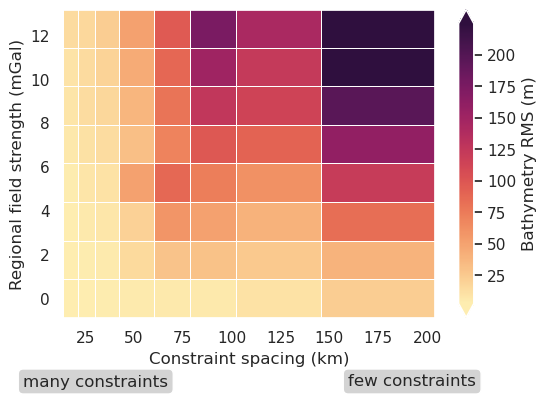

In [108]:
fig = RIS_plotting.plot_2var_ensemble(
    sampled_params_df,
    figsize=(6, 4),
    x="constraint_spacing",
    y="regional_rms",
    x_title="Constraint spacing (km)",
    y_title="Regional field strength (mGal)",
    background="inversion_rmse",
    background_title="Bathymetry RMS (m)",
    # background_cpt_lims=[10, 150],
    # background="regional_error",
    # background_title="Regional error (mGal)",
    # background="topo_improvement",
    # background_title="Topography improvement (m)",
    # background_cmap="cmo.matter_r",
    # plot_contours=[0],
    # plot_title="Constraint spacing vs regional strength",
    background_robust=True,
)
bbox = dict(facecolor="lightgray", boxstyle="round")
plt.gcf().text(
    0.3, -0.05, "many constraints", fontsize=12, va="center", ha="right", bbox=bbox
)
plt.gcf().text(
    0.6, -0.05, "few constraints", fontsize=12, va="center", ha="left", bbox=bbox
)

fig
# Results
# expected relationship between constraint spacing, regional strength and inversion performance

# with lots of constraints, regional field is unimportant for inversion performance
# with few constraints, regional field is important for inversion performance
# with low regional field, constraints are unimportant for inversion performance
# with high regional field, constraints are important for inversion performance

# Discussion
# with low regional strength, no point in having more constraints
# with high regional strength, each additional constraint improves inversion performance

In [84]:
polar_utils.get_min_max(sampled_params_df.topo_improvement_rmse, robust=True)

(np.float64(-37.878826468425686), np.float64(325.1632468209204))

Text(0.6, -0.05, 'few constraints')

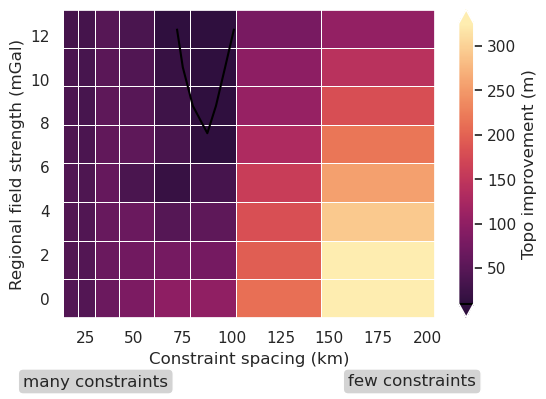

In [109]:
fig = RIS_plotting.plot_2var_ensemble(
    sampled_params_df,
    figsize=(6, 4),
    x="constraint_spacing",
    y="regional_rms",
    x_title="Constraint spacing (km)",
    y_title="Regional field strength (mGal)",
    background="topo_improvement_rmse",
    background_title="Topo improvement (m)",
    background_cmap="cmo.matter_r",
    background_robust=True,
    background_cpt_lims=(
        10,
        polar_utils.get_min_max(sampled_params_df.topo_improvement_rmse, robust=True)[
            1
        ],
    ),
    # background_cpt_lims=[0,200],
    # background_lims=(0, sampled_params_df.topo_improvement.max()),
    plot_contours=[0],
    # plot_title="Constraint spacing vs regional strength",
)
bbox = dict(facecolor="lightgray", boxstyle="round")
plt.gcf().text(
    0.3, -0.05, "many constraints", fontsize=12, va="center", ha="right", bbox=bbox
)
plt.gcf().text(
    0.6, -0.05, "few constraints", fontsize=12, va="center", ha="left", bbox=bbox
)

# Results
# expected relationship between constraint spacing, regional strength and inversion performance

# with lots of constraints, regional field is unimportant for improvement
# with few constraints, best improvement for low regional strength
# topo improvement mostly tied to number of constraints
# with few constraints, regional is important for improvement

# Discussion
# always with inversion if low regional
# if high regional, actually get better improvement with fewer constraints

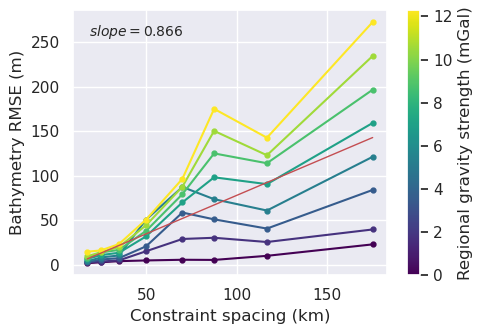

In [88]:
RIS_plotting.plot_ensemble_as_lines(
    sampled_params_df,
    y="inversion_rmse",
    x="constraint_spacing",
    groupby_col="regional_rms",
    x_label="Constraint spacing (km)",
    cbar_label="Regional gravity strength (mGal)",
    trend_line=True,
    # horizontal_line=starting_bathymetry_rmse,
    # horizontal_line_label="Starting RMSE",
)
# constraint spacing more important for high regional
# linear improvement to inversion with more constraints

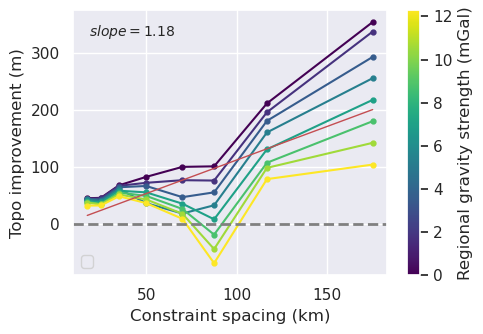

In [90]:
RIS_plotting.plot_ensemble_as_lines(
    sampled_params_df,
    y="topo_improvement_rmse",
    x="constraint_spacing",
    groupby_col="regional_rms",
    y_label="Topo improvement (m)",
    x_label="Constraint spacing (km)",
    cbar_label="Regional gravity strength (mGal)",
    trend_line=True,
    horizontal_line=0,
    # horizontal_line_label="Starting RMSE",
)
# linear inverse relation between inversion improvement and number of constraints
# even for lots of constraints, still worth inverting

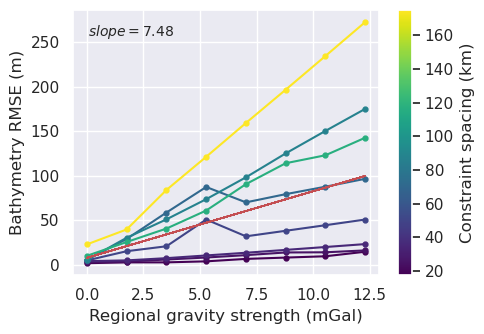

In [92]:
RIS_plotting.plot_ensemble_as_lines(
    sampled_params_df,
    y="inversion_rmse",
    x="regional_rms",
    groupby_col="constraint_spacing",
    x_label="Regional gravity strength (mGal)",
    cbar_label="Constraint spacing (km)",
    trend_line=True,
    # horizontal_line=0,
    # horizontal_line_label="Starting RMSE",
)
# linear relation between regional strength and inversion performance
# with few constraints, regional field strength is really important
# with lots of constraints, regional field strength doesn't matter

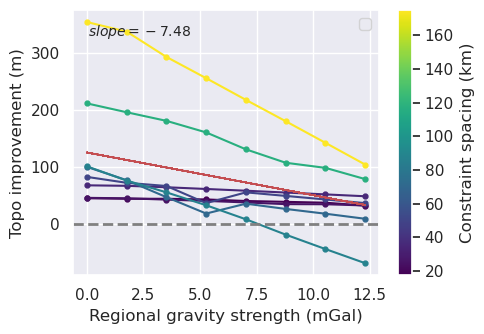

In [93]:
RIS_plotting.plot_ensemble_as_lines(
    sampled_params_df,
    y="topo_improvement_rmse",
    x="regional_rms",
    groupby_col="constraint_spacing",
    y_label="Topo improvement (m)",
    x_label="Regional gravity strength (mGal)",
    cbar_label="Constraint spacing (km)",
    trend_line=True,
    horizontal_line=0,
    # horizontal_line_label="Starting RMSE",
)
# linear relationship between regional field strength and improvement
# with few constraints, much more improvement with low regional